# Header

``` bash
conda create --name py2 python=2.7
source activate py2
conda install numpy scipy networkx pandas

conda install ipykernel
python -m ipykernel install --user --name py2 --display-name "py2"
```

In [28]:
from toolbox import wrappers
import pandas as pd
import numpy as np
import pickle

# String network

## Background

In [ ]:
fname = "../data/string/9606.protein.links.full.v11.0.txt"
net = pd.read_csv(fname,sep='\s')
print(net.shape)

In [ ]:
net.head(3)

## Network weight (string combined score)

In [ ]:
from calc_string_combined_score import calc_combined_score

In [ ]:
combined_score_list = calc_combined_score()

In [ ]:
import pickle

with open('../data/string/9606.protein.seleted_fields_combined_score.pkl', 'wb') as f:
    pickle.dump(combined_score_list, f)  

In [ ]:
len(combined_score_list)

In [ ]:
# net['sel_combined_score'] = x
with open('../data/string/9606.protein.seleted_fields_with_combined_score.pkl', 'wb') as f:
    pickle.dump(net, f)  

The minimum required interaction score puts a threshold on the confidence score, such that only interaction above this score are included in the predicted network. Lower score mean more interaction, but also more false positives. The confidence score is the approximate probability that a predicted link exists between two enzymes in the same metabolic map in the KEGG database. Confidence limits are as follows:

low confidence - 0.15 (or better),
medium confidence - 0.4,
high confidence - 0.7,
highest confidence - 0.9.

In the file: "protein.links.txt" are the scores multiplied by 1000?
Yes, the scores are multiplies by a factor 1000 (and truncated). 872 in the file means a STRING score of 0.872

## Select high confident edges
Run from hereafter

The minimum required interaction score puts a threshold on the confidence score, such that only interaction above this score are included in the predicted network. Lower score mean more interaction, but also more false positives. The confidence score is the approximate probability that a predicted link exists between two enzymes in the same metabolic map in the KEGG database. Confidence limits are as follows:

- low confidence - 0.15 (or better),
- medium confidence - 0.4,
- high confidence - 0.7,
- highest confidence - 0.9.

In [ ]:
net = pickle.load(open('../data/string/9606.protein.seleted_fields_with_combined_score.pkl','r'))
print(net.shape)
net.head(3)

In [ ]:
thres = 900 # 
snet = net[(net['coexpression']>thres) | (net['experiments']>thres) | (net['database']>thres)]
print(snet.shape)
print(snet['protein1'].unique().shape)
snet.head(3)

In [ ]:
with open('../data/network/9606.snet.pkl', 'wb') as f:
    pickle.dump(snet, f)  

In [ ]:
snet['sel_combined_score'] = snet['sel_combined_score'] / 1000
snet = snet[['protein1','sel_combined_score','protein2']]

snet.to_csv('../data/network/9606.snet.sif', sep='\t', header=False, index=False)

## Target modules

do online conversion from gene name to stringid on [here](https://string-db.org/cgi/input.pl?sessionId=iHDF0pGhGtH7&input_page_active_form=multiple_identifiers)

results here ../data/string/string_mapping_*.tsv

In [23]:
file_name = "../data/network/9606.snet.sif"
network = wrappers.get_network(file_name, only_lcc = True, use_edge_data = True)
net_nodes = set(network.nodes())

Shrinking network to its LCC 12479 331370
Final shape: 12107 331082


In [24]:
m1 = pd.read_csv('../data/network/string_mapping_TargetModule_IFN.tsv',sep='\t', index_col=1).index.tolist()
m2 = pd.read_csv('../data/network/string_mapping_TargetModule_cytokine.tsv',sep='\t', index_col=1).index.tolist()

nodes_to = set(m1) | set(m2)
len(nodes_to)

294

In [21]:
source = pd.read_csv('../data/network/Both_targets.csv', index_col=0)
nodes_from = list(set([x.strip() for l in source['Target'] for x in l.split(',')]))
len(nodes_from)

462

In [30]:
pwd

u'/home/fangyuan/home2/projects/qsp/codes'

In [29]:
bg_nodes = np.loadtxt('../data/geneset/REACTOME_IMMUNE_SYSTEM.txt',dtype='object')[2:]
bg_nodes

IOError: ../data/geneset/REACTOME_IMMUNE_SYSTEM.txt not found.

In [7]:
source_dict = pd.read_csv('../data/network/string_mapping_DrugTargetsHannah.tsv',sep='\t', index_col=1)['stringId']
source = pd.read_csv('../data/network/Both_targets.csv', index_col=0)['Target']


In [8]:
m1 = pd.read_csv('../data/network/string_mapping_TargetModule_IFN.tsv',sep='\t', index_col=1)['stringId'].tolist()
m2 = pd.read_csv('../data/network/string_mapping_TargetModule_cytokine.tsv',sep='\t', index_col=1)['stringId'].tolist()

print(len(m1), len(m2))

module_dict = {
    'IFN':m1,
    'Cytokine':m2,
}

(121, 184)


In [9]:
res_list = []
nodes_net = list(network.nodes)

for drug in source.index:
    
    tmp = []
    nodes_from = [x.strip() for x in source[drug].split(',')]
    nodes_from_ensp = [source_dict[x] for x in nodes_from if source_dict[x] in nodes_net]
    
    for module_name, nodes_to in module_dict.items():
        
        nodes_to_ensp = [x for x in nodes_to if x in nodes_net]
        d, z, (mean, sd) = wrappers.calculate_proximity(network, nodes_from_ensp, nodes_to_ensp, min_bin_size = 1000, seed=452456)
        print('##',d,z)
        tmp.extend([d,z,mean,sd])
    
    res_list.append(tmp)
    
res_df = pd.DataFrame(data=np.array(res_list), index=source.index, columns=[m+'_'+x
                                                                            for m in module_dict for x in ['d','z','mean','sd']])

TypeError: 'NoneType' object is not iterable

In [ ]:
wrappers.calculate_proximity(network, nodes_from_ensp, nodes_to_ensp, min_bin_size = 2, seed=452456)

# Sketch

## Network Calc

Network and dist can workout

In [ ]:
# from toolbox import network_utilities
# ?network_utilities.get_nodes_and_edges_from_sif_file
# from toolbox import wrappers
# import pandas as pd
# import pickle

In [ ]:
import networkx
networkx.__path__

In [ ]:
# use py2 
file_name = "proximity/data/toy.sif"
network = wrappers.get_network(file_name, only_lcc = True, use_edge_data=True)

nodes_from = ["A", "C"]
nodes_to = ["B", "D", "E"]
d, z, (mean, sd) = wrappers.calculate_proximity(network, nodes_from, nodes_to, min_bin_size = 2, seed=452456)
# to use edge weight in calc, use vscode debug
# I modified toolbox/network_utilities.py line 283, return networkx.shortest_path_length(G, source_id, target_id, weight='w')(added weight='w' to consider weight)
print (d, z, (mean, sd))
network.edges.data('w')

Net can be input with weight, Dist can be calc with weight

In [ ]:
network

In [ ]:
for e,w in network.edges.iteritems():
    u,v = e
    network[u][v]['weight']=.1 #,{'w':w})

In [ ]:
network.edges.data('weight')

In [ ]:
from networkx.algorithms.shortest_paths.generic import shortest_path_length

shortest_path_length(network,'C','F', weight=None), shortest_path_length(network,'C','F', weight='weight')


In [ ]:
tmp.head(3)

In [ ]:
tmp = pd.read_csv('../data/network/lung_PPI.txt', sep='\t')
tmp['w'] = [1]*tmp.shape[0]
tmp = tmp[['protein1','w','protein2']]
tmp.to_csv('../data/network/lung_PPI.sif', sep='\t', index=False)

net = wrappers.get_network('../data/network/lung_PPI.sif',only_lcc = True, use_edge_data=False)
net

## Overlap of Stringdb with Gene modules

### A test: DEGs

In [ ]:
up_genes = pd.read_csv('../data/string/string_mapping_input_up_genes.tsv',sep='\t')['stringId'].values
down_genes = pd.read_csv('../data/string/string_mapping_input_down_genes.tsv',sep='\t')['stringId'].values

In [ ]:
print(len(up_genes),len(down_genes)) 

print(sum([x in snet['protein1'].tolist() or x in snet['protein2'].tolist() for x in up_genes]))
print(sum([x in snet['protein1'].tolist() or x in snet['protein2'].tolist() for x in down_genes]))

In [ ]:
snet['weight'] = [1] * snet.shape[0]
snet_o = snet['protein1','weight','protein2']
snet_o.to_csv('')

### GO: IFN response and cytokines
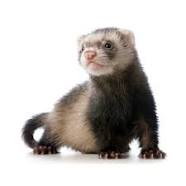
- Heatmap of Type-I IFN responses was constructed on DEGs belonging to the following GO annotations: GO:0035457, GO:0035458, GO:0035455, GO:0035456, GO:0034340； and add IFN I and III genes themselves
- Heatmap as in (D) for genes belonging to GO annotations for cytokine activity and chemokine activity (GO: 0005125, GO: 0008009).
- However, although IAV induces a greater number of genes, SARS-CoV-2 generates a unique gene signature enriched for cell death and leukocyte activation, including transcripts such as IL1A and CXCL8 (GO: 0008219 and GO: 0045431; Table S3)

In [ ]:
12107 * 331082  / (3194 * 51648)

## Time Estimation

``` bash
Warning: Ignored extra columns in the file!
Shrinking network to its LCC 12479 331370
Final shape: 12107 331082
(110, 169)
('APHA-compound-8', 1, 1)
('JAK3-Inhibitor-II', 24, 23)
('PU-H71', 1, 1)
('Benzatropine', 19, 16)
('AS-703026 (Pimasertib)', 2, 2)
('7b-cis', 1, 1)
('Saracatinib', 5, 5)
('WH-4023', 3, 3)
('Hydrocortisone', 5, 4)
('AZ-628', 3, 3)
('Xylazine', 3, 3)
('UNC-0321', 2, 2)
('GDC-0879', 4, 4)
('VU-0415374-1', 3, 3)
('Thalidomide', 12, 12)
('XMD-1150', 1, 1)
('JWE-035', 1, 1)
('GANT-58', 3, 3)
('RHO-kinase-inhibitor-III (rockout)', 4, 4)
('Profenamine', 5, 4)
('SB-205384', 3, 3)
('GR-235', 5, 5)
('SB-590885', 1, 1)
('Halometasone', 1, 1)
('Desipramine', 39, 21)
('Fulvestrant', 7, 7)
('KIN001-242', 1, 1)
('ALW-II-38-3', 6, 5)
('TPCA-1', 26, 26)
('Cyproterone', 3, 3)
('Apicidin', 12, 12)
('Clebopride', 3, 3)
('Cisapride', 20, 20)
('THM-I-94', 6, 6)
('LY-364947', 4, 4)
('NBQX', 8, 8)
('Dephostatin', 2, 2)
('Triprolidine', 1, 1)
('Triptolide', 4, 4)
('Levocetirizine', 2, 2)
('Quercetagetin', 2, 2)
('Altrenogest', 1, 1)
('EHNA', 9, 9)
('RO-3306', 1, 1)
('RG-13022', 3, 3)
('Isoxsuprine', 1, 1)
('Tivozanib', 6, 6)
('LY-2140023', 2, 2)
('Carteolol', 2, 2)
('BRD-A80383043', 2, 2)
('ML-9', 4, 3)
('Pirlindole', 5, 3)
('Droxinostat', 2, 2)
('Ciglitazone', 4, 4)
('Z-Pro-Prolinal', 2, 1)
(55, 230) # 55 drugs computed, 230 hours needed (excluding Fostamatinib with 255 targets and Fedratinib with 64 targets)
```